In [1]:
import math
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

import numpy as np
import time
from numpy import arange, sin, pi, random

from pyspark import SparkContext

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Anomaly"]

In [2]:
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util import common
from bigdl.util.common import *

sc = SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[4]").set("spark.driver.memory","2g"))
init_engine()

## Read data from csv

In [3]:
df = pd.read_csv("data/CPU_example.csv")

In [4]:
df.shape

(360000, 3)

In [5]:
df.head()

,Time,CPU,Class
0,0,0.668029,0
1,1,-0.087067,0
2,2,0.108378,0
3,3,0.227231,0
4,4,0.295954,0


## Basic sanity check of data and normalization

In [6]:
# check for null data
df.isnull().values.any()

# Standard scaling : mean 0, stddev 1
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df['CPU'] = preprocessing.StandardScaler().fit_transform(df['CPU'].values.reshape(-1, 1))
df.head()

,Time,CPU,Class
0,0,0.865492,0
1,1,-3.241536,0
2,2,-2.178497,0
3,3,-1.532043,0
4,4,-1.158252,0


<bound method Series.count of 0    164913
1    195087
Name: Class, dtype: int64>


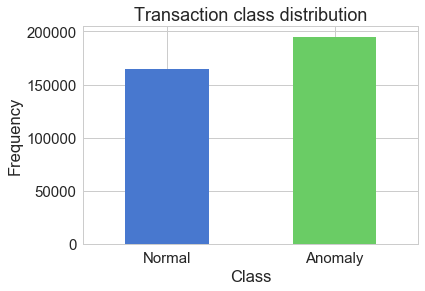

In [7]:
# let's explore the distribution of input data
count_classes = pd.value_counts(df['Class'], sort = False)
print(count_classes.count)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [8]:
# Just checking the relative counts
anomaly = df[df.Class == 1]
normal = df[df.Class == 0]

anomaly.shape

(195087, 3)

In [9]:
normal.shape

(164913, 3)

In [10]:
anomaly.CPU.describe()

count    195087.000000
mean          0.498250
std           0.558490
min          -2.015789
25%           0.128281
50%           0.497397
75%           0.864789
max          17.236686
Name: CPU, dtype: float64

In [11]:
normal.CPU.describe()

count    164913.000000
mean         -0.589415
std           1.083011
min          -5.633301
25%          -1.322399
50%          -0.588820
75%           0.145245
max           4.008205
Name: CPU, dtype: float64

## Any correlation between time and CPU metrics ?

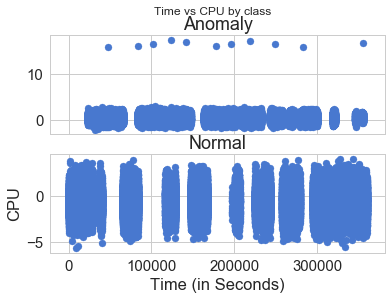

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time vs CPU by class')

ax1.scatter(anomaly.Time, anomaly.CPU)
ax1.set_title('Anomaly')

ax2.scatter(normal.Time, normal.CPU)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('CPU')
plt.show()

## Feature Re-engineering

In [13]:
indexed_df = df.set_index(["Time"])
df = indexed_df.rolling(10).mean()  ## mean over rolling window of size 10

df.loc[df['Class'] > 0.5, 'Class'] = 1.0
df.loc[df['Class'] <= 0.5, 'Class'] = 0.0

df = df[np.isfinite(df['CPU'])]  ## remove NaNs

In [14]:
df.head()

,CPU,Class
Time,,
9,-0.605786,0.0
10,-0.830194,0.0
11,-0.524666,0.0
12,-0.500997,0.0
13,-0.368182,0.0


## Split into training and test data

In [15]:
X_train, X_test = train_test_split(df.values[:, 1:2], test_size=0.2, random_state=RANDOM_SEED)
Y_train, Y_test = train_test_split(df.values[:, -1], test_size=0.2, random_state=RANDOM_SEED)

In [16]:
X_train.shape

(287992, 1)

In [17]:
X_test.shape

(71999, 1)

In [18]:
Y_train.shape

(287992,)

In [19]:
Y_test.shape
class_0 = list(filter(lambda x: x == 0.0, Y_test)) 
class_1 = list(filter(lambda x: x == 1.0, Y_test)) 
print(len(class_0), len(class_1))

32966 39033


In order to get data into BigDL engine we need to convert the numpy arrays into Spark RDD. Here's a helper function that does this. Note that we will use negative log likelihood for loss computation - hence based on the documentation of BigDL, the labels need to start from 1. Hence we add a 1 in the function below to all the labels.

In [20]:
def get_rdd_from_ndarray(sc):
    rdd_X_train = sc.parallelize(X_train)
    rdd_Y_train = sc.parallelize(Y_train)
    rdd_X_test = sc.parallelize(X_test)
    rdd_Y_test = sc.parallelize(Y_test)

    rdd_train_sample = rdd_X_train.zip(rdd_Y_train).map(lambda labeledFeatures:
                                       common.Sample.from_ndarray(labeledFeatures[0], labeledFeatures[1]+1))
    rdd_test_sample = rdd_X_test.zip(rdd_Y_test).map(lambda labeledFeatures:
                                     common.Sample.from_ndarray(labeledFeatures[0], labeledFeatures[1]+1))
    return (rdd_train_sample, rdd_test_sample)

(train_data, test_data) = get_rdd_from_ndarray(sc)

# Build the Model

In [21]:
# create a graph model

## initial layer with relu
initial = Linear(X_train.shape[1], 1)()
relu1 = ReLU()(initial)

## first hidden layer with relu and dropout
hidden1 = Linear(1, 16)(relu1)
relu2 = ReLU()(hidden1)
dropout1 = Dropout(0.2)(relu2)

## second hidden layer with relu and dropout
hidden2 = Linear(16, 32)(dropout1)
relu3 = ReLU()(hidden2)
dropout2 = Dropout(0.2)(relu3)

## third hidden layer with relu and dropout
hidden3 = Linear(32, 8)(dropout2)
relu4 = ReLU()(hidden3)
dropout3 = Dropout(0.6)(relu4)

## output layer with softmax(2) and dropout
output = Linear(8, 2)(dropout3)
softmax = SoftMax()(output)

model = Model([initial], [softmax])

creating: createLinear
creating: createReLU
creating: createLinear
creating: createReLU
creating: createDropout
creating: createLinear
creating: createReLU
creating: createDropout
creating: createLinear
creating: createReLU
creating: createDropout
creating: createLinear
creating: createSoftMax
creating: createModel


## Optimize and Train

In [22]:
learning_rate = 0.01
training_epochs = 8
batch_size = 256

# Create an Optimizer
optimizer = Optimizer(
    model = model,
    training_rdd = train_data,
    criterion = ClassNLLCriterion(),
    optim_method = SGD(learningrate=learning_rate),
    end_trigger = MaxEpoch(training_epochs),
    batch_size = batch_size)

# Set the validation logic
optimizer.set_validation(
    batch_size = batch_size,
    val_rdd = test_data,
    trigger = EveryEpoch(),
    val_method = [Top1Accuracy()]
)

log_dir = 'mylogdir'

app_name='anomaly-cpu-' + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir=log_dir, app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
val_summary = ValidationSummary(log_dir=log_dir, app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print("saving logs to ", app_name)

creating: createClassNLLCriterion
creating: createDefault
creating: createSGD
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createEveryEpoch
creating: createTop1Accuracy
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
saving logs to  anomaly-cpu-20180517-120634


In [23]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print("Optimization Done.")

Optimization Done.
CPU times: user 8.87 ms, sys: 3.92 ms, total: 12.8 ms
Wall time: 1min 45s


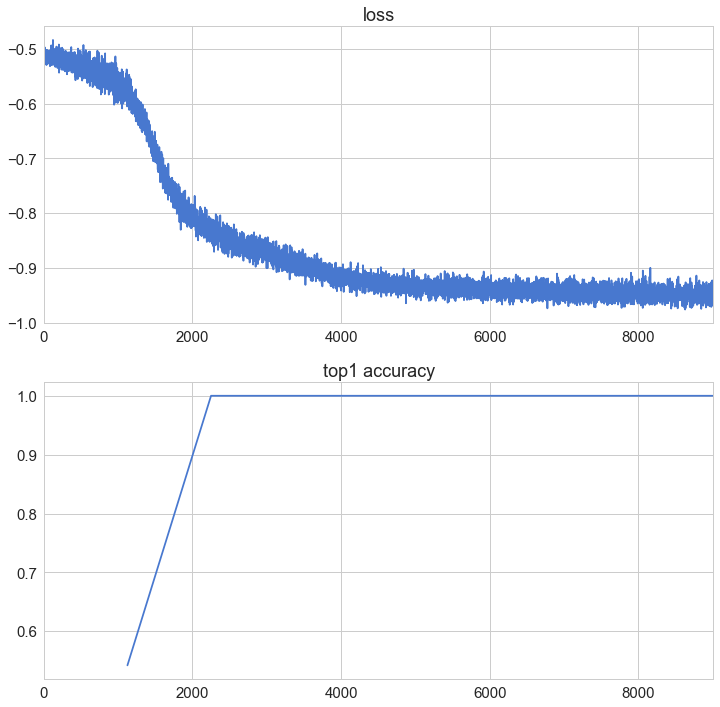

In [24]:
model.save_tensorflow([("input", [1, 1])], "/tmp/model.pb")

loss = np.array(train_summary.read_scalar("Loss"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")
plt.subplot(2,1,2)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0]+10)
plt.title("top1 accuracy")
plt.grid(True)


# Now predict on test set

In [25]:
def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return int(l[0] - 1)

In [26]:
predictions = trained_model.predict(test_data)

In [27]:
%%time
predictions = trained_model.predict(test_data)
print('Ground Truth labels:')
print(', '.join(str(map_groundtruth_label(s.label.to_ndarray())) for s in test_data.take(20)))
print('Predicted labels:')
print(', '.join(str(map_predict_label(s)) for s in predictions.take(20)))

Ground Truth labels:
0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1
Predicted labels:
0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1
CPU times: user 12.3 ms, sys: 3.22 ms, total: 15.5 ms
Wall time: 265 ms
